In [1]:
import pandas as pd 
import numpy as np

# Reads csv file and stores data, displays data information, and return the number of empty values in the data set
df = pd.read_csv('OnlineRetail.csv', encoding = 'latin1')
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# Removes duplicates and transactions that are zero or negative
df.drop_duplicates(inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

In [8]:
# Removes transactions that have no customer ID
df.dropna(subset=['CustomerID'], inplace=True)

In [10]:
# Creates new collumn for total price as quantity multiplied by unit price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [19]:
import datetime as dt
# Sets reference date to December 10, 2011
reference_date = dt.datetime(2011, 12, 10)
# Converts Invoice Data to date time format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Group data by customer ID and calculates recency by invoice date, frequency by invoice number, and monetary by total price 
rfm = df.groupby('CustomerID').agg(
    {'InvoiceDate': lambda x: (reference_date - x.max()).days,'InvoiceNo': 'nunique', 'TotalPrice': 'sum'}).rename(
        columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency','TotalPrice': 'Monetary'})

In [20]:
# Gets log transformation of monetary values to deal with outliers
rfm['Monetary'] = np.log1p(rfm['Monetary'])

In [21]:
from sklearn.cluster import KMeans
# Applies clustering algorithm to segment customers and create a machine learnng algorithm for the RFM
kmeans = KMeans(n_clusters=5,random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm[['Recency', 'Frequency', 'Monetary']])

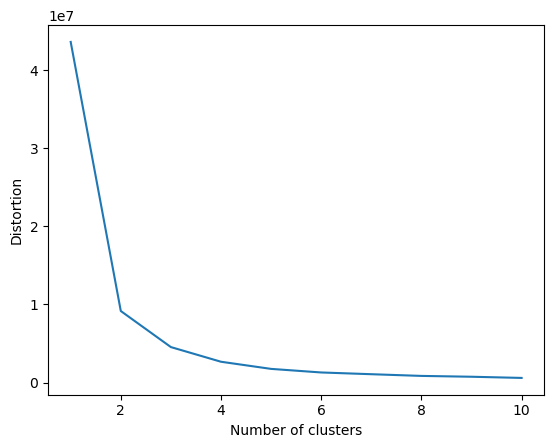

In [23]:
import matplotlib.pyplot as plt
# Uses Kmeans to plots line of best fit for distortions vs number of clusters
distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm[['Recency','Frequency','Monetary']])
    distortions.append(kmeans.inertia_)

plt.plot(range(1, 11), distortions)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()
# More clusters means less distortion

In [ ]:
from sklearn.metrics import silhouette_score
# Silhouette score measures cluster quality 
silhouette_avg = silhouette_score(rfm[['Recency','Frequency','Monetary']], rfm['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.5932583842439269


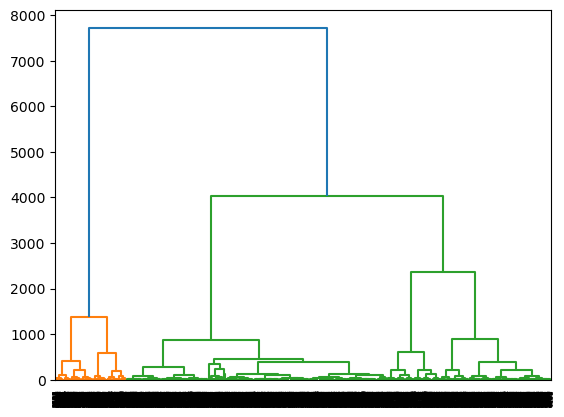

In [27]:
from scipy.cluster.hierarchy import dendrogram, linkage
# Applies hierarchial clustering to visualize the hierarchy of the customer groups
Z = linkage(rfm[['Recency','Frequency','Monetary']], method = 'ward')
dendrogram(Z)
plt.show()


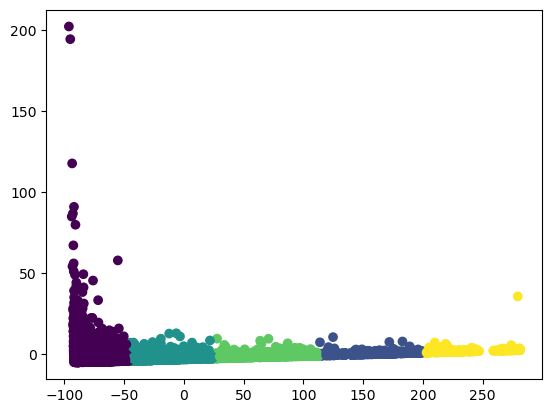

In [26]:
from sklearn.decomposition import PCA
# Uses PCA to reduce dimensionality of clustering features 
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm[['Recency','Frequency','Monetary']])
plt.scatter(rfm_pca[:, 0], rfm_pca[:, 1], c=rfm['Cluster'])
plt.show()